## Scientific Computing II - UFRJ

### Project 1 - ODEs Systems

#### Student  : Leonardo Bohac

In [1]:
import numpy   as np
import scipy.special

import matplotlib.pyplot as plt

In [2]:
arange    = np.arange
array     = np.array
exp       = np.exp
eye       = np.eye
hstack    = np.hstack
imag      = np.imag
linspace  = np.linspace
log10     = np.log10
newaxis   = np.newaxis
real      = np.real
repeat    = np.repeat
unique    = np.unique
eye       = np.eye
vstack    = np.vstack
zeros     = np.zeros
det       = np.linalg.det
eig       = np.linalg.eig
inv       = np.linalg.inv
power     = np.linalg.matrix_power
factorial = scipy.special.factorial

In [3]:
def Defective(A, tol=1e-12):
    """ 
    Returns False if matrix A is non-defective; True otherwise.
    
    Commentaries: *This function can only make sense when applied to a square matrix.

                  *The eigenvalues are rounded up to some number of tolerant decimal places. 
                   This prevents floating-point imprecisions when asking if two eigenvalues are equal.
                   Eigenvalues very close to each other will be considered the same.
  
                  *The return statement can be interpreted as: If all eigenvalues are distinct, 
                   then the matrix is non-defective. If there are repeated eigenvalues,
                   the matrix will be defective iff its eigenvectors are linearly dependent.
                   
    """
    
    A = array(A)
    
    try:
        
        assert(A.shape[0] == A.shape[1])
        
    except:
        print('Matrix is not square, returning None.')
        return
    
    EVs   = eig(A)
    eigva = EVs[0]
    eigve = EVs[1]
    
    eigva = np.round(eigva , decimals=int(-log10(tol)))
    
    return (unique(eigva).size != eigva.size) & (abs(det(eigve)) < tol)

In [4]:
def Solve_ODEs_Linear_System(A, b, initial_u, init_t=0, finl_t=1, stepsize=1e-3):
    """
    Returns the solution for a linear system of ODEs with constant coefficients.
    
    The linear system is: 
    
                                    u'(t) = Au(t) + b
                                    
                                    u(0)  = initial_u
                                    
                                    
    where u(t) is the vector of unknown functions, and u'(t) is its (row-wise) derivative with respect to time. 
    

    The number of unknown functions is n.
    
    
    Dimensions : A         :: n x n
                 b         :: n x 1
                 initial_u :: n x 1
                 u(t)      :: n x s (this is the output; it contains the values of all n functions 
                                     along each step in time)
                 
    """ 
    
    A         = array(A)
    b         = array(b)
    initial_u = array(initial_u)
    
    try:
        
        assert(A.shape[0] == A.shape[1])
        
    except:
        print('Matrix is not square, returning None.')
        return
    
    def Exp(A, T, iters=10):
        """
        This function returns eᴬᵀ. The uppercase T indicates that 
        the exponential will be computed for all the time values at once (not only 
        for a single t value) in a vectorized-fashion.
        """
        s = len(T)
        
        if(Defective(A)):

            I = arange(iters).reshape(-1,1)
            
            M = [power(A,0)]
            for i in range(1,iters):
                M.append(M[-1]@A) 
            M = array(M)
            M = repeat(M[newaxis,:],s,axis=0)
            
            C = (np.repeat(T[newaxis,:], iters, axis=0)**I/factorial(I)).T[...,newaxis,newaxis]
            
            return (M*C).sum(axis=1) # Taylor's Expansion formula
        
        else:
            
            EVs   = eig(A)
            eigva = EVs[0]
            eigve = EVs[1]

            L = repeat(eye(A.shape[0])[newaxis,:],s,axis=0)*exp(eigva*T[:,newaxis])[...,newaxis]

            return eigve @ L @ inv(eigve) # Eigendecomposition formula
        
    
    s = int((finl_t - init_t)/stepsize) + 1
    
    T = linspace(init_t, finl_t, s)
    
    E = Exp(A,T)

    if(not b.any()):
        # System is homogeneous
        return (E@initial_u).T  # Complete solution for homogeneous system
    
    if(det(A) == 0):
        print('Cannot solve non-homogenous system with A being singular. Returning None.')
        return
    
    I = repeat(eye(A.shape[0])[newaxis,:],s,axis=0)

    return (E@initial_u).T + inv(A)@((E-I)@b).T  # Complete solution for non-homogeneous system

In [5]:
def Plot_ODEs_Linear_System_Solution(A, b, initial_u, init_t=0, finl_t=2, stepsize=1e-3):

    Solution = Solve_ODEs_Linear_System(A, b, initial_u, init_t, finl_t, stepsize)
    
    if(Solution is None):
        return
    
    if(Solution.dtype == np.complex128):
        if(abs(imag(Solution)).max() > 1e-12):
            print('Solution is complex-valued. Casting to real part only.')
        Solution = real(Solution)
    
    T = linspace(init_t, finl_t, Solution.shape[1])
    
    plt.figure(figsize=(16,8))
    plt.plot(T, Solution.T)

In [6]:
A  = [[  1,  3,  1,  3],
      [ -1,  1,  0,  3],
      [  2,  1,  1, -1],
      [ -4,  2, -3, -1]]


b         = [0,0,0,0]

initial_u = [1,1,1,1]

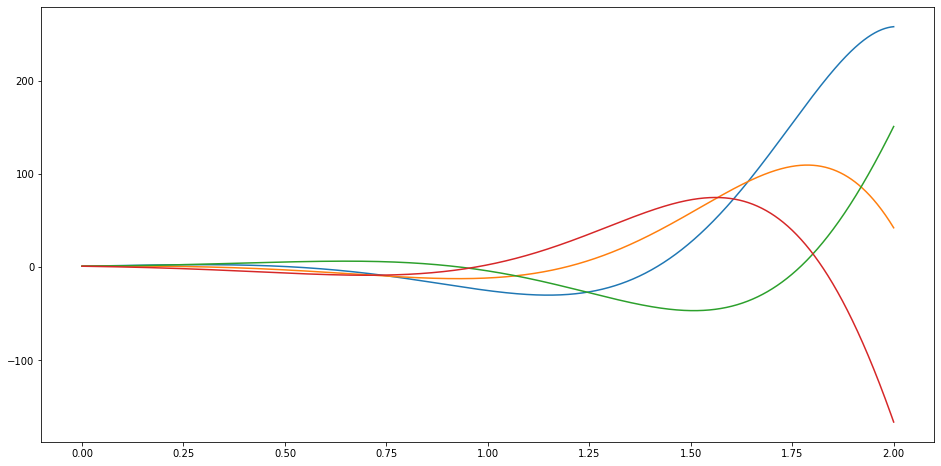

In [7]:
Plot_ODEs_Linear_System_Solution(A, b, initial_u)

In [8]:
def Solve_Constant_Coefficients_Linear_ODE(Coeffs, IC):
    """ 
    Returns the solution for an ODE of the form:
    
                                [a0, a1, ..., an]·[u(t)_0, u(t)_1, ..., u(t)_n] = k
                                        
    with initial condition
    
                                U(0) = [u(0)_0, u(0)_1, ..., u(0)_n]
                                     
    
    where 
    
            u(t)_j → j-th derivative of u(t)
            
            aj     → constant number (for any j)
            
            k      → constant number
            
    
    As an intermediate step, this ｎ-order ODE will be reduced to a linear system of ｎ 1-order ODEs.
    
    This can be done by exploring the relations within the solution's vector U(t) (i.e. the components are
    derivatives of one another). Each of these yields an equation for the desired linear system.
    
    The rearrangement comes as:
    
    
    
    [  0    1    0    …      0   ] [   u_0   ]            [   u_1   ]       [ 0 ]

    [  0    0    1    …      0   ] [   u_1   ]            [   u_2   ]       [ 0 ]
    
            ⋮         ⋱                 ⋮           =          ⋮        -     ⋮  
    
    [  0    0    0    …      1   ] [ u_(n-2) ]            [ u_(n-1) ]       [ 0 ]
    
    [-a0  -a1  -a2    …  -a(n-1) ] [ u_(n-1) ]            [   u_n   ]       [ k ]
    
   
   
   
   which is equivalent to a system  
   
   
                                    AU = U' - b   ∴   U' = AU + b
            
                
    """
    
    Coeffs = array(Coeffs)
    Ic     = array(IC)
    
    n = len(Coeffs) - 2
    
    try:
        
        assert(n == len(IC))
        
    except:
        print('Dimension mismatch. Check if Coeffs and IC are the right sizes. Returning None.')
        return
    
    Coeffs = Coeffs/Coeffs[0]
    
    A = vstack([hstack([zeros(n-1)[:,newaxis],eye(n-1)]), -Coeffs[-2:0:-1]])
    
    b = hstack([zeros(n-1), Coeffs[-1]])

    return Solve_ODEs_Linear_System(A, b, IC)

In [9]:
def Plot_Linear_ODE_Solution(Coeffs, IC, init_t=0, finl_t=2):

    Solution = Solve_Constant_Coefficients_Linear_ODE(Coeffs, IC)
    
    if(Solution is None):
        return
    
    Solution = Solution[0]
    
    if(Solution.dtype == np.complex128):
        if(abs(imag(Solution)).max() > 1e-12):
            print('Solution is complex-valued. Casting to real part only.')
        Solution = real(Solution)
    
    T = linspace(init_t, finl_t, len(Solution))
    
    plt.figure(figsize=(16,8))
    plt.plot(T, Solution.T)

In [10]:
Coeffs = [2, -1, 1, 10]

IC     = [1,0]

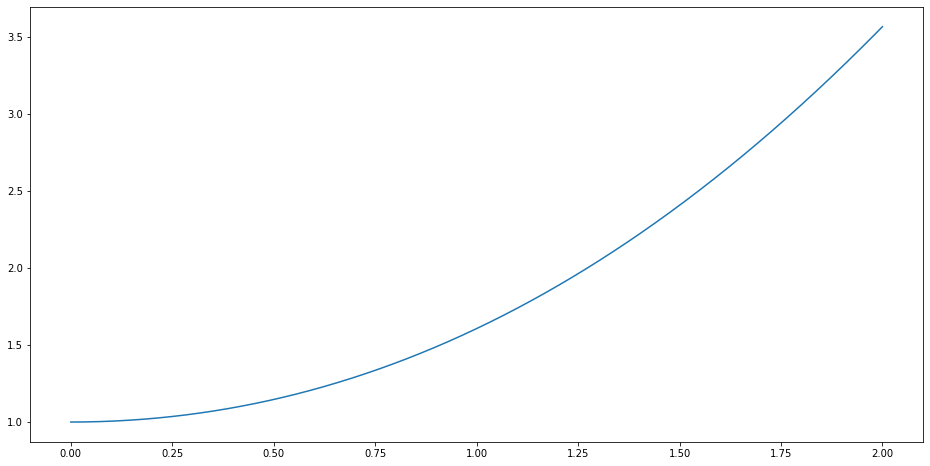

In [11]:
Plot_Linear_ODE_Solution(Coeffs, IC)